# Housing Data Workflow Notebook

Modular workflow where you can run individual steps independently.
Run cells in order or skip any steps you don't need.

Each step shows dataframe views and statistics for inspection.

## Quick Start
- Run **Setup** cell first
- Then run any combination of Step 1-4 cells
- Skip cells you don't want to execute
- Each cell is self-contained and shows results

## 🔧 Setup

Run this cell first to import modules and define helper functions.

In [1]:
import sys
from pathlib import Path
from typing import Optional
import time

import pandas as pd

# Add current directory to path for local imports
sys.path.append(".")

# Import our workflow modules
from fetch_affordable_housing_data import update_local_data, verify_and_fetch_hpd_data
from query_ll44_funding import query_and_add_financing
from query_dob_filings import query_dob_filings
from query_co_filings import query_co_filings
from HPD_DOB_Join_On_BIN import create_separate_timelines
from create_timeline_chart import create_timeline_chart, create_financing_charts
from data_quality import quality_tracker

print("✅ All imports successful")

# Helper functions
def _normalize_bin(bin_value) -> Optional[str]:
    """Normalize BIN to a clean string."""
    if pd.isna(bin_value):
        return None
    try:
        return str(int(float(bin_value)))
    except (TypeError, ValueError):
        value = str(bin_value).strip()
        return value or None

def _write_bin_file(source_csv: Path, output_txt: Path) -> Path:
    """Extract BINs from a CSV and write them to a text file for CO searches."""
    df = pd.read_csv(source_csv)
    candidate_cols = [col for col in df.columns if col.lower() in ("bin", "bin_normalized")]
    if not candidate_cols:
        raise SystemExit(f"Could not find a BIN column in {source_csv}")

    bins = [_normalize_bin(val) for val in df[candidate_cols[0]].dropna()]
    bins = sorted({b for b in bins if b})

    output_txt.parent.mkdir(parents=True, exist_ok=True)
    output_txt.write_text("\n".join(bins))
    print(f"Wrote {len(bins)} BINs to {output_txt}")
    return output_txt

print("✅ Helper functions defined")

✅ All imports successful
✅ Helper functions defined


## 📥 Step 1: Fetch HPD Data

Load or refresh the HPD affordable housing dataset.

**Options:**
- Set `refresh_data = True` to fetch fresh data
- Set `refresh_data = False` to use existing data

In [2]:
# Step 1 Configuration
refresh_data = False  # Set to True to fetch fresh HPD data
hpd_output_path = "data/raw/Affordable_Housing_Production_by_Building.csv"  # Output path for HPD data
refresh_hpd_projects = False  # Set to True to fetch fresh HPD projects data

print("=" * 70)
print("STEP 1: FETCH HPD DATA")
print("=" * 70)

# Start quality tracking

# Handle HPD projects cache refresh if requested
if refresh_hpd_projects:
    print("Force refreshing HPD projects cache...")
    from fetch_affordable_housing_data import verify_and_fetch_hpd_projects_data
    hpd_projects_df, hpd_projects_path = verify_and_fetch_hpd_projects_data(use_existing=False)
    print(f"HPD projects cache refreshed: {len(hpd_projects_df)} records\n")

quality_tracker.start_processing()

if refresh_data:
    print("Fetching fresh HPD data from NYC Open Data...")
    hpd_df, hpd_csv = update_local_data(hpd_output_path)
else:
    print("Verifying local HPD data against API...")
    hpd_df, hpd_csv = verify_and_fetch_hpd_data(output_path=hpd_output_path, use_projects_cache=not refresh_hpd_projects)

if not hpd_csv.exists():
    raise SystemExit(f"HPD dataset not found at {hpd_csv}")

# Record initial dataset size

# Get total units before filter
original_count = len(hpd_df)
original_units = hpd_df['Total Units'].sum()

# Filter to New Construction only
hpd_df = hpd_df[hpd_df["Reporting Construction Type"] == "New Construction"].copy()

filtered_count = len(hpd_df)
filtered_units = hpd_df['Total Units'].sum()
filtered_out = original_count - filtered_count
filtered_units_out = original_units - filtered_units

print(f"🏗️ Filtered to New Construction only:")
print(f"  Original: {original_count:,} projects, {original_units:,} total units")
print(f"  Filtered: {filtered_count:,} projects ({filtered_count/original_count*100:.1f}%), {filtered_units:,} total units ({filtered_units/original_units*100:.1f}%)")
print(f"  Removed: {filtered_out:,} non-new construction projects ({filtered_out/original_count*100:.1f}%), {filtered_units_out:,} units filtered out ({filtered_units_out/original_units*100:.1f}%)")

quality_tracker.analyze_hpd_data(hpd_df, "Full_HPD_Dataset")
quality_tracker.record_pipeline_stage("raw_hpd_data", len(hpd_df), "Raw HPD affordable housing dataset")

print(f"✅ Step 1 complete: {len(hpd_df):,} records loaded")
print(f"📁 Data location: {hpd_csv}")

# Display the dataframe
print("\n🔍 HPD Dataset Overview:")
print(f"Shape: {hpd_df.shape}")
print("\nColumns:")
for col in hpd_df.columns:
    print(f"  - {col}")

print("\n📊 Sample Data:")
display(hpd_df.head())
print("\n📈 Basic Statistics:")
display(hpd_df.describe(include="all"))

STEP 1: FETCH HPD DATA
Verifying local HPD data against API...
STEP 1: VERIFY AND FETCH HPD DATA
Found local HPD data file: data/raw/Affordable_Housing_Production_by_Building.csv
Local file has 8,604 records

Fetching 100 sample records from API for verification...
Fetching affordable housing data from NYC Open Data API...
Endpoint: https://data.cityofnewyork.us/resource/hg8x-zxpr.json
Fetching records 1-100...
  Retrieved 100 records (total: 100)

Completed! Retrieved 100 total records

Enriching building data with project-level information...
VERIFYING HPD PROJECTS CACHE
HPD projects cache file is stale (age: 0:01:16.240451) or use_existing=False
Fetching fresh data from API...
Created backup: data/raw/Affordable_Housing_Production_by_Project.csv.backup_20251130_100156
Fetching HPD Projects data from NYC Open Data API...
Endpoint: https://data.cityofnewyork.us/resource/hq68-rnsi.json
Fetching records 1-1000...
  Retrieved 1000 records (total: 1,000)
Fetching records 1001-2000...
  Re

,Project ID,Project Name,Project Start Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,...,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units,Program Group,Project Completion Date,Extended Affordability Status,Planned Tax Benefit
0,44218,MEC E. 125TH ST. PARCEL B WEST,2018-12-31T00:00:00.000,987329,2319,3 AVENUE,Manhattan,10035,1017907501,1054682,...,NaN,NaN,297.0,NaN,297.0,404,Multifamily Finance Program,2022-02-16T00:00:00.000,No,Article XI
1,44223,ROCHESTER SUYDAM PHASE 1,2021-06-30T00:00:00.000,927737,335,RALPH AVENUE,Brooklyn,11233,3015560003,3000000,...,NaN,NaN,NaN,13.0,13.0,13,Multifamily Finance Program,2024-09-24T00:00:00.000,No,Article XI
2,44223,ROCHESTER SUYDAM PHASE 1,2021-06-30T00:00:00.000,969695,35,ROCHESTER AVENUE,Brooklyn,11233,3017090009,3000000,...,NaN,NaN,NaN,8.0,8.0,8,Multifamily Finance Program,2024-09-24T00:00:00.000,No,Article XI
3,44223,ROCHESTER SUYDAM PHASE 1,2021-06-30T00:00:00.000,975702,18-22,SUYDAM PLACE,Brooklyn,11233,3017090028,3000000,...,NaN,NaN,NaN,15.0,15.0,15,Multifamily Finance Program,2024-09-24T00:00:00.000,No,Article XI
4,44223,ROCHESTER SUYDAM PHASE 1,2021-06-30T00:00:00.000,977564,329,RALPH AVENUE,Brooklyn,11233,3015560007,3000000,...,NaN,NaN,NaN,10.0,10.0,10,Multifamily Finance Program,2024-09-24T00:00:00.000,No,Article XI



📈 Basic Statistics:


,Project ID,Project Name,Project Start Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,...,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units,Program Group,Project Completion Date,Extended Affordability Status,Planned Tax Benefit
count,4216,4216,4216,3184,4216,4216,4216,3182,3115,3115,...,12.0,106.000000,3029.000000,1276.000000,4206.000000,4216.000000,4216,3297,4216,3113
unique,3749,2718,1850,3162,1965,1048,5,146,3007,2397,...,NaN,NaN,NaN,NaN,NaN,NaN,4,1437,2,8
top,53017,CONFIDENTIAL,2016-06-27T00:00:00.000,975696,----,----,Brooklyn,11239,2035150020,3000000,...,NaN,NaN,NaN,NaN,NaN,NaN,Multifamily Incentives Program,2019-05-28T00:00:00.000,No,421a
freq,83,1032,84,2,1032,1032,1873,165,9,331,...,NaN,NaN,NaN,NaN,NaN,NaN,2412,83,4214,2332
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.688679,37.684714,1.639498,27.636472,52.016129,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,6.993008,67.426568,4.116363,59.488316,107.460375,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.000000,3.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.000000,9.000000,1.000000,5.000000,10.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.000000,38.000000,1.000000,20.000000,50.000000,NaN,NaN,NaN,NaN


In [3]:
# How many unique counts are there by project id as primary key per program group,
# and show total units in parentheticals (but NOT for the unique project counts).

# Compute total units per Program Group (all rows)
units_per_group = hpd_df.groupby('Program Group')['Total Units'].sum()

print("Program Group counts (raw rows) (total units in parentheses):")
raw_row_counts = hpd_df['Program Group'].value_counts()
for group, count in raw_row_counts.items():
    units = units_per_group.get(group, 0)
    print(f"{group}: {count} rows ({units} units)")
print()

# Group by Program Group, count unique Project IDs
unique_proj_counts = hpd_df.groupby('Program Group')['Project ID'].nunique().sort_values(ascending=False)
unique_proj_ids = (
    hpd_df
    .groupby('Program Group')
    .apply(lambda df: df['Project ID'].unique())
)

print("Program Group counts (unique Project ID as primary key):")
for group, count in unique_proj_counts.items():
    print(f"{group}: {count} projects")
print()

print("\nTax Abatement by Program Group (based on unique Project ID):")
if 'Planned Tax Benefit' in hpd_df.columns:
    # For this, deduplicate by Project ID first
    unique_project_rows = hpd_df.drop_duplicates(subset=['Project ID'])
    tax_abate_ct = (
        unique_project_rows
        .groupby('Program Group')['Planned Tax Benefit']
        .value_counts(dropna=False)
        .unstack(fill_value=0)
        .sort_index(axis=1)
    )
    # Also display total units per Program Group in this table, if desired
    units_per_group_project = unique_project_rows.groupby('Program Group')['Total Units'].sum()
    print("Total units (unique Project ID per Program Group):")
    display(units_per_group_project)
    display(tax_abate_ct)
else:
    print("Column 'Planned Tax Benefit' not found in dataset.")

# Make a version of this with unit count by program and tax benefit
if 'Planned Tax Benefit' in unique_project_rows.columns and 'Program Group' in unique_project_rows.columns:
    units_pivot = (
        unique_project_rows
        .groupby(['Program Group', 'Planned Tax Benefit'])['Total Units']
        .sum()
        .unstack(fill_value=0)
        .sort_index(axis=1)
    )
    print("Total units by Program Group and Planned Tax Benefit (unique Project ID only):")
    display(units_pivot)
else:
    print("Required columns not found for unit pivot table.")

# Calculate average units per year by Program Group and Planned Tax Benefit

if 'Project Start Date' in unique_project_rows.columns and 'Total Units' in unique_project_rows.columns:
    # Extract year from 'Project Start Date'
    unique_project_rows = unique_project_rows.copy()
    unique_project_rows['Project Year'] = pd.to_datetime(unique_project_rows['Project Start Date'], errors='coerce').dt.year

    avg_units_per_year = (
        unique_project_rows
        .groupby(['Program Group', 'Planned Tax Benefit', 'Project Year'])['Total Units']
        .sum()
        .reset_index()
    )

    # Now calculate the average units per year by program group and tax abatement
    avg_units_table = (
        avg_units_per_year
        .groupby(['Program Group', 'Planned Tax Benefit'])['Total Units']
        .mean()
        .unstack(fill_value=0)
        .sort_index(axis=1)
    )
    print("Average units per year by Program Group and Planned Tax Benefit (unique Project ID only):")
    display(avg_units_table)
else:
    print("Required columns not found for average units per year table.")



Program Group counts (raw rows) (total units in parentheses):
Multifamily Incentives Program: 2412 rows (152021 units)
Homeowner Assistance Program: 1027 rows (1027 units)
Multifamily Finance Program: 581 rows (64796 units)
Small Homes Program: 196 rows (1456 units)

Program Group counts (unique Project ID as primary key):
Multifamily Incentives Program: 2304 projects
Homeowner Assistance Program: 1027 projects
Multifamily Finance Program: 382 projects
Small Homes Program: 36 projects


Tax Abatement by Program Group (based on unique Project ID):
Total units (unique Project ID per Program Group):


/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_1754/2851651086.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df['Project ID'].unique())


Program Group
Homeowner Assistance Program        1027
Multifamily Finance Program        57976
Multifamily Incentives Program    147060
Small Homes Program                  933
Name: Total Units, dtype: int64

Planned Tax Benefit,420a,420c,421a,467-M,485-X,Article IV,Article XI,UDAAP,NaN
Program Group,,,,,,,,,
Homeowner Assistance Program,0,0,0,0,0,0,0,0,1027
Multifamily Finance Program,3,255,24,0,0,0,75,2,23
Multifamily Incentives Program,1,30,2205,2,32,0,11,0,23
Small Homes Program,0,14,3,0,0,1,8,6,4


Total units by Program Group and Planned Tax Benefit (unique Project ID only):


Planned Tax Benefit,420a,420c,421a,467-M,485-X,Article IV,Article XI,UDAAP
Program Group,,,,,,,,
Multifamily Finance Program,233,36567,3806,0,0,0,13718,4
Multifamily Incentives Program,318,4271,136252,630,1068,0,449,0
Small Homes Program,0,485,80,0,0,6,229,16


Average units per year by Program Group and Planned Tax Benefit (unique Project ID only):


Planned Tax Benefit,420a,420c,421a,467-M,485-X,Article IV,Article XI,UDAAP
Program Group,,,,,,,,
Multifamily Finance Program,116.5,3047.250000,634.333333,0.0,0.0,0.0,1143.166667,2.0
Multifamily Incentives Program,318.0,388.272727,11354.333333,630.0,534.0,0.0,89.800000,0.0
Small Homes Program,0.0,53.888889,26.666667,0.0,0.0,6.0,38.166667,4.0


/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_1754/2814624407.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', len(tax_benefits))
/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_1754/2814624407.py:93: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles_tax = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black', label=f"{tax_benefits[i]}") for i in range(len(tax_benefits))]


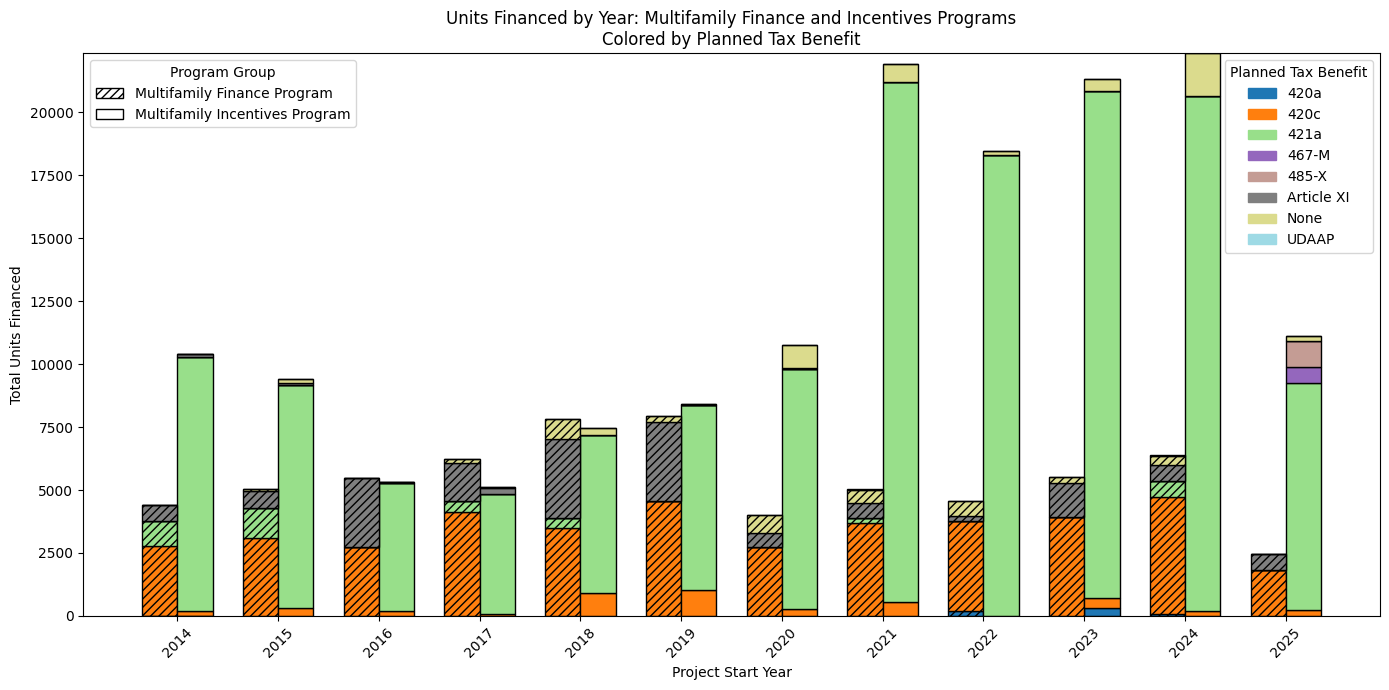

In [4]:
import matplotlib.pyplot as plt

# We'll use the full raw HPD data, because we want all programs, not just Multifamily Finance Program
if 'Project Start Date' in hpd_df.columns and 'Total Units' in hpd_df.columns:
    hpd_bar_df = hpd_df.copy()
    hpd_bar_df['Project Year'] = pd.to_datetime(hpd_bar_df['Project Start Date'], errors='coerce').dt.year

    # Only focus on desired groups
    programs_of_interest = ['Multifamily Finance Program', 'Multifamily Incentives Program']
    mask = hpd_bar_df['Program Group'].isin(programs_of_interest)
    hpd_bar_df = hpd_bar_df[mask & hpd_bar_df['Project Year'].notna()]

    # Fill NAs in Planned Tax Benefit with "None"
    hpd_bar_df['Planned Tax Benefit'] = hpd_bar_df['Planned Tax Benefit'].fillna('None')

    # Prepare for grouped bar with stack
    # Pivot: rows = Project Year, columns = (Program Group, Planned Tax Benefit), values = sum of units
    pivot = (
        hpd_bar_df
        .groupby(['Project Year', 'Program Group', 'Planned Tax Benefit'])['Total Units']
        .sum()
        .reset_index()
    )

    # Ensure proper order of years and programs
    years = sorted(pivot['Project Year'].dropna().unique())
    tax_benefits = sorted(pivot['Planned Tax Benefit'].unique())
    # Keep consistent order for bars
    program_order = ['Multifamily Finance Program', 'Multifamily Incentives Program']

    # Prepare data structure: for each year, for each program, get breakdown by tax benefit
    bar_data = {}
    for year in years:
        bar_data[year] = {}
        for prog in program_order:
            mask = (pivot['Project Year'] == year) & (pivot['Program Group'] == prog)
            year_prog_data = pivot[mask].set_index('Planned Tax Benefit')['Total Units'].reindex(tax_benefits, fill_value=0)
            bar_data[year][prog] = year_prog_data.values

    # Number of bars per group (2 programs), group by year, stacked by tax benefit
    x = range(len(years))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 7))

    # Colors for planned tax benefits
    import matplotlib.cm as cm
    color_map = cm.get_cmap('tab20', len(tax_benefits))
    colors = [color_map(i) for i in range(len(tax_benefits))]

    bottoms_p1 = [0] * len(years)
    bottoms_p2 = [0] * len(years)

    # For each tax benefit, draw the stack pieces for both programs
    legend_handles = []
    for idx, tax in enumerate(tax_benefits):
        values_p1 = [bar_data[year][program_order[0]][idx] for year in years]
        values_p2 = [bar_data[year][program_order[1]][idx] for year in years]

        bar1 = ax.bar(
            [i - width/2 for i in x], values_p1, width,
            bottom=bottoms_p1, color=colors[idx],
            label=tax if (tax not in [h.get_label() for h in legend_handles]) else None,
            edgecolor='black', hatch='////'
        )
        bar2 = ax.bar(
            [i + width/2 for i in x], values_p2, width,
            bottom=bottoms_p2, color=colors[idx],
            label=None,
            edgecolor='black'
        )

        if tax not in [h.get_label() for h in legend_handles]:
            legend_handles.append(bar1)

        bottoms_p1 = [b + v for b, v in zip(bottoms_p1, values_p1)]
        bottoms_p2 = [b + v for b, v in zip(bottoms_p2, values_p2)]

    # Add year labels
    ax.set_xticks(x)
    ax.set_xticklabels([str(int(y)) for y in years], rotation=45)
    ax.set_xlabel("Project Start Year")
    ax.set_ylabel("Total Units Financed")
    ax.set_title("Units Financed by Year: Multifamily Finance and Incentives Programs\nColored by Planned Tax Benefit")

    # Custom legend for program groups
    import matplotlib.patches as mpatches
    progs = [
        mpatches.Patch(color='gray', label='Multifamily Finance Program', ec='black', hatch='////'),
        mpatches.Patch(color='gray', label='Multifamily Incentives Program', ec='black')
    ]
    # Only add one legend for planned tax benefit
    handles_tax = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black', label=f"{tax_benefits[i]}") for i in range(len(tax_benefits))]
    legend1 = ax.legend(handles=handles_tax, title="Planned Tax Benefit", loc='upper right')
    ax.add_artist(legend1)
    # Add manual tick legend for program bars
    bar_locs = [x[0] - width/2, x[0] + width/2]
    ax.bar(bar_locs[0], 0, width, color='white', hatch='////', ec='black', label='Multifamily Finance Program')
    ax.bar(bar_locs[1], 0, width, color='white', ec='black', label='Multifamily Incentives Program')
    ax.legend(
        handles=[
            plt.Rectangle((0,0),1,1, facecolor='white', hatch='////', edgecolor='black', label='Multifamily Finance Program'),
            plt.Rectangle((0,0),1,1, facecolor='white', edgecolor='black', label='Multifamily Incentives Program')
        ], title="Program Group", loc='upper left'
    )

    ax.grid(True, which='major', axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns ('Project Start Date', 'Total Units') not found in HPD Data.")



## 🏗️ Step 3A: Query DOB Filings

Search for DOB New Building filings.

**Depends on:** Step 2
**Options:**
- Set `skip_dob = True` to use existing DOB data
- Set `use_bbl_fallback = False` to disable BBL fallback

In [4]:
# Step 3A Configuration
skip_dob = False  # Set to True to use existing DOB data
use_bbl_fallback = True  # Set to False to disable BBL fallback
dob_output_path = None  # Custom DOB output path
building_csv = hpd_csv  # Use HPD data directly (skipping financing step)

# Filter to Multifamily Finance Program only
print(f"Reading HPD data from {building_csv}")
hpd_df = pd.read_csv(building_csv)
original_count = len(hpd_df)
print(f"Loaded {original_count:,} total buildings")

# Apply filters: New Construction + Multifamily Finance Program
filtered_df = hpd_df[
    (hpd_df["Reporting Construction Type"] == "New Construction") &
    (hpd_df["Program Group"] == "Multifamily Finance Program")
]
filtered_count = len(filtered_df)

print(f"🏗️ Filtered to Multifamily Finance Program:")
print(f"  Original: {original_count:,} buildings")
print(f"  Filtered: {filtered_count:,} buildings ({filtered_count/original_count*100:.1f}%)")

# Save filtered data for DOB processing
import tempfile
temp_fd, temp_path = tempfile.mkstemp(suffix="_multifamily_finance.csv")
import os
os.close(temp_fd)  # Close the file descriptor
filtered_df.to_csv(temp_path, index=False)
building_csv = Path(temp_path)
print(f"📁 Using filtered dataset: {filtered_count:,} Multifamily Finance Program buildings")



print("\n" + "=" * 70)
print("STEP 3A: QUERY DOB FILINGS")
print("=" * 70)

dob_output = Path(dob_output_path) if dob_output_path else Path(
    f"data/processed/{building_csv.stem}_dob_filings.csv"
)
dob_output.parent.mkdir(parents=True, exist_ok=True)

# Check for existing DOB files when skipping
if skip_dob:
    print("⏭️ Using existing DOB data")
    # Look for existing files
    alt_dob_path = Path(f"data/external/{building_csv.stem}_dob_filings.csv")
    if dob_output.exists():
        print(f"📁 Using existing DOB data at {dob_output}")
        dob_df = pd.read_csv(dob_output)
    elif alt_dob_path.exists():
        print(f"📁 Using existing DOB data from external folder: {alt_dob_path}")
        dob_output = alt_dob_path
        dob_df = pd.read_csv(dob_output)
    else:
        print("⚠️ No existing DOB data found")
        dob_df = None
        dob_output = None
else:
    print(f"🔍 Querying DOB APIs using {building_csv} -> {dob_output}")
    print("   This may take several minutes...")
    query_dob_filings(
        str(building_csv),
        output_path=str(dob_output),
        use_bbl_fallback=use_bbl_fallback,
    )
    print(f"✅ DOB query completed: {dob_output}")
    dob_df = pd.read_csv(dob_output)

# Display DOB data if available
if dob_df is not None:
    print(f"📊 DOB Filings Data: {dob_df.shape[0]} records")
    print("Columns:")
    for col in dob_df.columns:
        print(f"  - {col}")
    
    print("\n📊 Sample DOB Data:")
    display(dob_df.head())
    
    # Show some statistics
    if "filing_date" in dob_df.columns:
        print("\n📈 DOB Filing Date Statistics:")
        display(dob_df["filing_date"].describe())
else:
    print("⚠️ No DOB data available")

Reading HPD data from data/raw/Affordable_Housing_Production_by_Building.csv
Loaded 8,604 total buildings
🏗️ Filtered to Multifamily Finance Program:
  Original: 8,604 buildings
  Filtered: 581 buildings (6.8%)
📁 Using filtered dataset: 581 Multifamily Finance Program buildings

STEP 3A: QUERY DOB FILINGS
🔍 Querying DOB APIs using /var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/tmpm0jy4ns8_multifamily_finance.csv -> data/processed/tmpm0jy4ns8_multifamily_finance_dob_filings.csv
   This may take several minutes...
Reading search data from CSV: /var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/tmpm0jy4ns8_multifamily_finance.csv
Found 548 BINs to search initially
STEP 1: QUERYING DOB APIs BY BIN

Querying API: https://data.cityofnewyork.us/resource/ic3t-wcy2.json
Looking for job type: NB
Search type: bin
Number of items to check: 548
  Querying batch 1 (Items 1-300)...
    Found 1753 records
  Querying batch 2 (Items 301-548)...
    Found 450 records

Total records found: 2203

Querying 

KeyboardInterrupt: 

In [15]:
def bbl_to_boro_block_lot_and_name(bbl):
    """
    Convert a NYC BBL (Borough-Block-Lot) string (like '3015560003') to a tuple:
    (borough_number, borough_name, block, lot).
    Borough number is int (1-5). Name is string ("Manhattan", "Bronx", ...).

    Example:
        bbl_to_boro_block_lot_and_name('3015560003')
        -> (3, 'Brooklyn', '01556', '0003')
    """
    boro_names = {
        1: "Manhattan",
        2: "Bronx",
        3: "Brooklyn",
        4: "Queens",
        5: "Staten Island",
    }
    bbl_str = str(bbl).zfill(10)
    borough_num = int(bbl_str[0])
    borough_name = boro_names.get(borough_num, "Unknown")
    block = bbl_str[1:6]
    lot = bbl_str[6:10]
    return (borough_num, borough_name, block, lot)

# Example usage
bbl_example = '3015560003'
boro_num, boro_name, block, lot = bbl_to_boro_block_lot_and_name(bbl_example)
print(f"BBL {bbl_example} -> Borough {boro_num} ({boro_name}), Block {block}, Lot {lot}")


BBL 3015560003 -> Borough 3 (Brooklyn), Block 01556, Lot 0003


## 🏛️ Step 3B: Query Certificate of Occupancy

Search for Certificate of Occupancy filings.

**Depends on:** Step 2
**Options:**
- Set `skip_co = True` to use existing CO data

In [ ]:
# Step 3B Configuration
skip_co = False  # Set to True to use existing CO data
co_output_path = None  # Custom CO output path

print("\n" + "=" * 70)
print("STEP 3B: QUERY CERTIFICATE OF OCCUPANCY")
print("=" * 70)

# Generate BIN file for CO searches
bin_output = Path("data/processed/workflow_bins.txt")
bin_file = _write_bin_file(building_csv, bin_output)

print(f"\n📋 BIN file created: {bin_file}")
print(f"Contains {len(bin_file.read_text().split())} BINs")

co_output = Path(co_output_path) if co_output_path else Path(
    f"data/processed/{bin_file.stem}_co_filings.csv"
)
co_output.parent.mkdir(parents=True, exist_ok=True)

if skip_co:
    print("⏭️ Using existing CO data")
    # Look for existing CO files
    alt_co_path = Path(f"data/external/{bin_file.stem}_co_filings.csv")
    if co_output.exists():
        print(f"📁 Using existing CO data at {co_output}")
        co_df = pd.read_csv(co_output)
    elif alt_co_path.exists():
        print(f"📁 Using existing CO data from external folder: {alt_co_path}")
        co_output = alt_co_path
        co_df = pd.read_csv(co_output)
    else:
        print("⚠️ No existing CO data found")
        co_df = None
        co_output = None
else:
    print(f"🏛️ Querying CO APIs using {bin_file} -> {co_output}")
    query_co_filings(str(bin_file), output_path=str(co_output))
    co_df = pd.read_csv(co_output)

# Display CO data if available
if co_df is not None:
    print(f"📊 Certificate of Occupancy Data: {co_df.shape[0]} records")
    print("Columns:")
    for col in co_df.columns:
        print(f"  - {col}")
    
    print("\n📊 Sample CO Data:")
    display(co_df.head())
    
    # Show some statistics
    if "issue_date" in co_df.columns:
        print("\n📈 CO Issue Date Statistics:")
        display(co_df["issue_date"].describe())
else:
    print("⚠️ No CO data available")

## 📊 Step 4: Generate Timelines and Charts

Create timeline visualizations from enriched data.

**Depends on:** Steps 2, 3A
**Options:**
- Set `skip_join = True` to skip timeline creation
- Set `skip_charts = True` to skip chart generation

In [ ]:
# Step 4 Configuration
skip_join = False   # Set to True to skip timeline creation
skip_charts = False # Set to True to skip chart generation

print("\n" + "=" * 70)
print("STEP 4: GENERATE TIMELINES AND CHARTS")
print("=" * 70)

if skip_join:
    print("⏭️ Skipping timeline join step.")
else:
    if dob_output is None or not dob_output.exists():
        print("⚠️ No DOB data available; skipping timeline creation.")
    else:
        print("🔗 Building timelines...")
        create_separate_timelines(
            str(building_csv),
            str(dob_output),
            str(co_output) if co_output else None,
        )
        
        # Load and display timeline data
        hpd_timeline = Path(str(building_csv).replace(".csv", "_hpd_financed_timeline.csv"))
        private_timeline = Path(str(building_csv).replace(".csv", "_privately_financed_timeline.csv"))
        
        if hpd_timeline.exists():
            hpd_timeline_df = pd.read_csv(hpd_timeline)
            print(f"\n📊 HPD Financed Timeline Data ({hpd_timeline_df.shape[0]} records):")
            display(hpd_timeline_df.head())
            
            # Show event type distribution
            if "event_type" in hpd_timeline_df.columns:
                print("\n📈 Event Types in HPD Timeline:")
                display(hpd_timeline_df["event_type"].value_counts())
        
        if private_timeline.exists():
            private_timeline_df = pd.read_csv(private_timeline)
            print(f"\n📊 Privately Financed Timeline Data ({private_timeline_df.shape[0]} records):")
            display(private_timeline_df.head())
            
            # Show event type distribution
            if "event_type" in private_timeline_df.columns:
                print("\n📈 Event Types in Private Timeline:")
                display(private_timeline_df["event_type"].value_counts())

if skip_charts:
    print("⏭️ Skipping chart generation.")
else:
    # Charts
    print("\n📈 Generating charts...")
    default_timeline_stem = "Affordable_Housing_Production_by_Building_with_financing"
    if Path(building_csv).name == f"{default_timeline_stem}.csv":
        create_financing_charts()
        print("✅ Created financing-specific charts")
    else:
        hpd_timeline = Path(str(building_csv).replace(".csv", "_hpd_financed_timeline.csv"))
        private_timeline = Path(str(building_csv).replace(".csv", "_privately_financed_timeline.csv"))
        
        if hpd_timeline.exists():
            create_timeline_chart(str(hpd_timeline))
            print(f"✅ Created HPD financed timeline chart")
        else:
            print(f"⚠️ No HPD financed timeline found; skipping.")

        if private_timeline.exists():
            create_timeline_chart(str(private_timeline))
            print(f"✅ Created privately financed timeline chart")
        else:
            print(f"⚠️ No privately financed timeline found; skipping.")

print("\n✅ Step 4 complete")

## 📋 Final Summary

Generate data quality report and workflow summary.

**Optional:** Run this at the end to see final statistics.

In [ ]:
print("\n" + "=" * 70)
print("📊 FINAL DATA QUALITY REPORT")
print("=" * 70)

# Generate final data quality report and Sankey diagram
quality_tracker.end_processing()
report_filename = quality_tracker.save_report_to_file("notebook_workflow")
sankey_filename = quality_tracker.generate_sankey_diagram()
quality_tracker.print_report()

print("\n🎉 WORKFLOW COMPLETED!")
print(f"📊 Data quality report: {report_filename}")
if sankey_filename:
    print(f"📊 Sankey diagram: {sankey_filename}")

# Summary of what we accomplished
print("\n📋 WORKFLOW SUMMARY:")
try:
    print(f"• HPD Records Processed: {len(hpd_df):,}")
except NameError:
    print("• HPD Records: Step 1 not run")
try:
    print(f"• Records with Financing: {len(financing_df):,}")
except NameError:
    print("• Records with Financing: Step 2 not run")
try:
    if dob_df is not None:
        print(f"• DOB Filings Found: {len(dob_df):,}")
    else:
        print("• DOB Filings: No data")
except NameError:
    print("• DOB Filings: Step 3A not run")
try:
    if co_df is not None:
        print(f"• CO Filings Found: {len(co_df):,}")
    else:
        print("• CO Filings: No data")
except NameError:
    print("• CO Filings: Step 3B not run")

print("\n✅ Notebook workflow complete!")
print("Each step showed dataframe views for inspection.")